##### Comparing speed with age
* The Citibike data provides `start station latitude`, `start station longitude`, `end station latitude`, `end station longitude`, geolocation data as well as a `tripduration` in seconds. The cartesian distance was used to calculate the `miles per hour` _effective_ `speed` of someone's trip.
  * The data also includes the year of birth, but it became clear that there is also a lot of fake data,
  ```python
  df = load_data('data/201509_10-citibike-tripdata.csv.annotated.100000.06112016T1814.csv')
  ```
  
  * since from a random sample of `83171` subscriber trips taken in `2015 09` and `2015 10`, there are even people born in `1885`, 
  
  ```python
  In [6]: df['birth year'].describe()
Out[6]: 
count    83171.000000
mean      1977.149680
std         11.400096
min       1885.000000
25%       1969.000000
50%       1980.000000
75%       1986.000000
max       1999.000000
Name: birth year, dtype: float64
  ```
  

  * 


In [7]:
%matplotlib inline
from pipeline_data import load_data
import seaborn as sns
# from plottings import plot_age_speed

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [16]:
import numpy as np

In [5]:
df = load_data('data/201509_10-citibike-tripdata.csv.annotated.100000.06112016T1814.csv')

* Looking at all the data, the mean speed is around `6mph`.

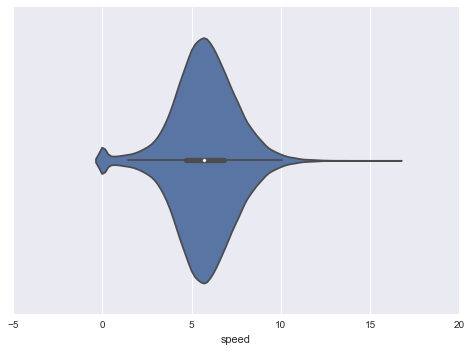

In [10]:
ax = sns.violinplot(x=df['speed'])

In [14]:
def get_age_bucket(age):
    return np.floor(age/10)

In [18]:
df['age_buckets'] = df.age.map(get_age_bucket)

###### For  age buckets from 1 (ages 10-19) and up, we can look at the speeds
* It looks like people riding from `30-39` are most common
```python
df['age_buckets'].value_counts()
Out[19]:
3     27847
2     22417
4     17386
5     10986
6      3492
1       649
7       368
11       16
8         5
13        3
10        2
Name: age_buckets, dtype: int64
```
* And there is also a pattern of the average `speed` going up a bit from `10-19` to `20-49` and then reducing afterwards.

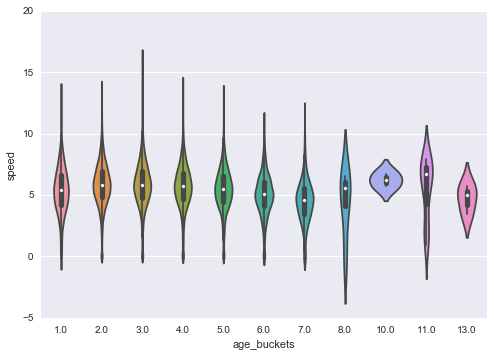

In [29]:
ax2 = sns.violinplot(data=df, x='age_buckets', y='speed')

##### The problem of predicting destination
* The next interesting problem encountered is looking at whether input data can be used to determine where a person is likely to end up, 
* In Citibike data, we have someone's `end station name` and `end station id`. 
* Using the earlier dataset from `September and October 2015`, 

In [33]:
df.shape

(83171, 33)

In [34]:
df['end station id'].value_counts().shape

(392,)

* We have `392` many end stations. Trying to predict a person's exact end station, directly, could easily lead to overfitting the data.
* Instead, the approach used was to make use of *geolocation* data from the Google maps API, to supplement the dataset with `zip code`, `neighborhood` and `sublocality`—a.k.a. `borough`—information. 

###### Approach of gathering geolocation data
* Geolocation code `get_station_geolocation_data.py get_station_geoloc_data()` makes calls to _https://googleapis.com_ , providing text addresses `'end station name'` from the Citibike dataset such as `1st Avenue & E 15th St, NY`—which are zip code and borough amibguous—and the API returns a json representation with matches, 
```python
{
 'raw_result': [{u'address_components': [{u'long_name': u'1st Avenue',
                  u'short_name': u'1st Avenue',
                  u'types': [u'route']},
                 {u'long_name': u'Midtown',
                  u'short_name': u'Midtown',
                  u'types': [u'neighborhood',
                             u'political']},
                 {u'long_name': u'Manhattan',
                  u'short_name': u'Manhattan',
                  u'types': [u'sublocality_level_1',
                             u'sublocality',
                             u'political']},
                 {u'long_name': u'New York',
                  u'short_name': u'New York',
                  u'types': [u'locality',
                             u'political']},
                 {u'long_name': u'New York County',
                  u'short_name': u'New York County',
                  u'types': [u'administrative_area_level_2',
                             u'political']},
                 {u'long_name': u'New York',
                  u'short_name': u'NY',
                  u'types': [u'administrative_area_level_1',
                             u'political']},
                 {u'long_name': u'United States',
                  u'short_name': u'US',
                  u'types': [u'country',
                             u'political']},
                 {u'long_name': u'10003',
                  u'short_name': u'10003',
                  u'types': [u'postal_code']}],
                 u'formatted_address': u'1st Avenue & E 15th St, New York, NY 10003, USA',
                 }
```

* This is parsed to the form, 
```python
{
'geo_results': {'neighborhood': u'Midtown',
                 'postal_code': u'10003',
                 'state': u'NY',
                 'sublocality': u'Manhattan'},
                 }
```
and it is also cached to redis.
* A station dataframe looks like
```
station_name	postal_code	sublocality	neighborhood	state
0	1 Ave & E 15 St	10003	Manhattan	Midtown	NY
1	1 Ave & E 18 St	10003	Manhattan	Midtown	NY
2	1 Ave & E 30 St	10016	Manhattan	Midtown	NY
3	1 Ave & E 44 St	10017	Manhattan	Midtown East	NY
4	1 Ave & E 62 St	10065	Manhattan	Upper East Side	NY
```

* In the code, `annotate_geolocation.py annotate_df_with_geoloc(df, station_df, noisy_nonmatches=False)` was written to join a regular dataset with a `station_df` dataframe.

###### Source time bucketing 
* In order to get better information from the source time, the source time was bucketted into 24 hour-buckets per day. That is since a ride starting at 1:04:23pm shouldn't be treated as being too different from a ride departing at 1:05:24pm . There is more value in intuitively clustering the rides.

* (ddce9001 Apr 10 2016 , ) Added label encoding


##### A basic learning strategy is used 
* `sklearn` is used for the investigations
* To do some learning, the input data is chosen, clean up work is necessary to deal with missing data and label encoding is needed to have a format which `sklearn` can work with.
  * Discarding the rows with missing columns will remove a small percent.

* (22e61f56; Feb 7 18:22:56 2016) Initially the `(start time bucket, start station id, age, gender)` are used , with `RandomizedLogisticRegression` as a classifier. 
* How does adding additional geolocation data help with accuracy?
* (2016-05-01 saved `pipeline_runner_05012016.html` ) ran a comparison with accuracy using just the `end station id` with annotated locations.

```python
{'end station id': OrderedDict([('training',
               OrderedDict([('accuracy_score', 0.041432771986099973),
                            ('f1_score', 0.015138704086611844),
                            ('recall_score', 0.041432771986099973),
                            ('precision_score', 0.016942125433308568)])),
              ('holdout',
               OrderedDict([('accuracy_score', 0.031533939070016032),
                            ('f1_score', 0.0093952628045424723),
                            ('recall_score', 0.031533939070016032),
                            ('precision_score', 0.0067157290264759353)]))]),
 'end_neighborhood': OrderedDict([('training',
               OrderedDict([('accuracy_score', 0.39047231270358307),
                            ('f1_score', 0.28885663229134789),
                            ('recall_score', 0.39047231270358307),
                            ('precision_score', 0.26445041603375502)])),
              ('holdout',
               OrderedDict([('accuracy_score', 0.39630836047774159),
                            ('f1_score', 0.2935527390151364),
                            ('recall_score', 0.39630836047774159),
                            ('precision_score', 0.26579390443173939)]))]),
 'end_postal_code': OrderedDict([('training',
               OrderedDict([('accuracy_score', 0.14129127122042506),
                            ('f1_score', 0.068340173428106887),
                            ('recall_score', 0.14129127122042506),
                            ('precision_score', 0.068168259430770747)])),
              ('holdout',
               OrderedDict([('accuracy_score', 0.13361838588989844),
                            ('f1_score', 0.064738931917963718),
                            ('recall_score', 0.13361838588989844),
                            ('precision_score', 0.067139580345228156)]))]),
 'end_sublocality': OrderedDict([('training',
               OrderedDict([('accuracy_score', 0.95354786589470852),
                            ('f1_score', 0.95209028150037733),
                            ('recall_score', 0.95354786589470852),
                            ('precision_score', 0.95217920885515972)])),
              ('holdout',
               OrderedDict([('accuracy_score', 0.9493807215939688),
                            ('f1_score', 0.94990282092170586),
                            ('recall_score', 0.9493807215939688),
                            ('precision_score', 0.95132373575480056)]))])}
```

* The above results indicate that it was a good experiment, 
with experiment_with_different_destination_cols() , to investigate predicting destinations,
much more narrowly than trying to predict the destination station id. The experiment
used choose_end_station_label_column() to annotate the main dataframe such that only 
one of [s.END_STATION_ID, s.NEW_END_POSTAL_CODE, s.NEW_END_NEIGHBORHOOD, s.NEW_END_BOROUGH] 
was used as the output label Y column during training and testing.

There are about 463 stations found in the dataset, 28 neighborhoods, 
representing 49 postal codes and 3 out of 5 boroughs,

The rough accuracies for prediction, 
end station id (~3%), postal code (~13%), neighborhood (~40%), and borough (~95%),
using the small dataset, shows the rough differences in what happens when you
reduce the number of possible outputs.

One of the next goals should be to focus on the neighborhood perhaps and make changes
in both the size of the data used and the learning algorithm used.

###### Running a groupby between the boroughs
```
grpby = my_annotated_df.groupby([s.NEW_START_BOROUGH,])
grouped_end_borough = grpby[s.NEW_END_BOROUGH]
grouped_end_borough.value_counts().to_csv(
    datetime.datetime.now().strftime('results/grouped_end_borough.%m%d%YT%H%M.csv')
    )

```
* This group by shows, below, the link counts represented in the dataset, 
'data/201510-citibike-tripdata.csv.annotated.mini.02212016T1641.csv'
which is a tiny 9709 row subset of the larger October 2015 dataset.
```
Brooklyn,Brooklyn,656
Brooklyn,Manhattan,253
Brooklyn,Queens,21
Manhattan,Manhattan,8275
Manhattan,Brooklyn,95
Manhattan,Queens,6
Queens,Queens,18
Queens,Manhattan,11
Queens,Brooklyn,2
```

* When using the start and end station meta data for classification, 
we can still only have one Y label column, so when training, only one of the
['end_neighborhood', 'end_sublocality', 'end_zipcode'] columns, can 
exist in the df.

-> so maybe the pipeline processing itself, should produce the three/four 
different kinds of output dataframes, for classification.

###### Also comparing with additional classifiers
* Other than Logistic Regression, also tried SGD as well as SGD with a Grid Search.
* (	7b51e59 , May 22 2016) Started trying SGD 
* For SGD Grid search, found that the `alpha` term getting selected was actually different based on the size of the input data.

* Foo
![alt text](plots/20160918-report/lr-sgd-no-scaling-comparison.png "Title")
* And
![alt text](plots/20160918-report/lr-sgd-with-scaling-comparison.png "Title")
* Comparing by accuracy score, predicting the 'end_sublocality' (a.k.a. borough) 
is the most reliable. And in most cases, feature standard scaling improves the SGD performance,
measuring by accuracy. But when it comes to predicting the neighborhood, although
both basic LR and SGD are doing pretty poorly around 40%, LR is doing much better than SGD here.
The note also is that SGD used here is w/o parameter tuning.

![alt text](plots/20160918-report/lr-sgd-with-scaling-comparison-chart.png "Title")

###### Use of Feature standard scaling 
* Here, `StandardScaler` is used from [scikitlearn](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) , fitting on the training data and then applying the per feature mean and variance scaling data to the test data used.
* Using the `StandardScaler`, makes features standard normally distributed, as per the recommendation on [scikitlearn](http://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use) . 

###### Parameter tuning on SGD with Grid Search
* Found that initial use of Grid Search on SGD to select `alpha` was not fruitful. 

![alt text](plots/20160918-report/lr-sgd-initial-grid-search-comparison.png)

* Above, sorting by accuracy, shows the results of SGD when Grid Search was used to select `alpha` for `[1e-06,0.1]`. Most likely, the problem may be that the `alpha` term is sensitive to the training data and these are the results when running SGD on a test set. 
* A follow on to the above point is that the way the training and test data are derived is essentially questionable. And some of the next steps needed are to try to make sure that the data is more reliable.

###### Varying training sample size 
* Another experiment [06/11/2016] was to observe the test set accuracy , with varying training set size.
* Using a single month of data to take samples from, and initially varying the input sample from 10,000 to 100,000 rows, the accuracy does not appear to have a good correlation below.

![alt text](plots/20160918-report/lr-training-set-size-comparison.png)

* This might mean that an independent holdout set is needed as opposed to training / testing from the same input data.
* Or more likely, since a month-size dataset is around 1.2 Million rows, then a 10,000 large set just ends up barely dipping into the first day. So choosing the dataset sizes has to be done, by random sampling.
* Randomness is definitely important to consider and looking at one of the input datasets confirmed this potential problem,

```
#10,000 dataset....
df1 = pd.read_csv('data/201509_10-citibike-tripdata.csv.annotated.10000.06112016T1813.csv')

df1['starttime'][:3], df1['starttime'][-3:] 

# ==> 
(0    9/1/2015 00:00:00
 1    9/1/2015 06:39:35
 2    9/1/2015 08:42:01
 Name: starttime, dtype: object, 9169    9/1/2015 08:24:00
 9170    9/1/2015 07:57:20
 9171    9/1/2015 08:40:08
 Name: starttime, dtype: object)
```

* After making the sampling randomized, the output below, feels like it has a better upward trend, but it is still not visible enough.

![alt text](plots/20160918-report/lr-training-set-size-comparison-randomized-sampling.png)



###### Using a Separate holdout test set
* Next, ( June 26, 2016) created ten models on sizes 10,000 through 100,000 datasets, created from 09 and 10 2015, and testing on a single holdout dataset, taken from November 2015. In this approach, the accuracy results are found using the same holdout set instead of using a differently derived test set each time. 
* This still however, doesn't appear to have better results. The results are actually flatter.

![alt text](plots/20160918-report/lr-holdout-size-comparison.png "testing on a holdout set instead of testing with different test sets each time")

* Next, trying to increase the training sets used for creating the models, by another order, with the below results. However, again, the results are a bit flat.

![alt text](plots/20160918-report/lr-holdout-size-comparison-million.png)

* These accuracy results, which are all in the 0.375 neighborhood, may be because the holdout is now being explicitly used here as from a separate month, as opposed to building a test set from the same input set.
* Maybe a better idea is to create an independent holdout from the same date range. Since the test data was derived from 09 and 10 2015 and the holdout was taken from Nov 2015, the seasonal differences are enough to throw off the results. 
* Or more fundamentally, the `0.375` flat accuracies could be indicators of a different kind of problem in the pipeline, which needs to be addressed.

###### Binarizing geolocation start data
* Another important modeling change to try was to do a better of job of preparing the input data to better expose the stratification across citibike trips across the sources. To do this, instead of using a source station column and source neighborhood columns, the source neighborhood column was binarized using the sklearn `OneHotEncoder`, to a column for each of the neighborhoods in the surface area of the city.
* The same experiment as earlier was conducted, comparing results across the default `SGDClassifier` and `LogisticRegression` classifiers and also across `100,000` to `1,000,000` size datasets used for a train/test split along with a `100,000` large holdout set.
* These were created from just the single `2015-09` dataset (`201509-citibike-tripdata.csv`).


In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [16]:
results_file = 'results/binarize_2016-11-09T2024.csv'
df = pd.read_csv(results_file)
df = df.iloc[:-11]
df.columns

Index([u'Unnamed: 0', u'indx', u'feature_standard_scaling',
       u'one_hot_encoding', u'dataset_size', u'label_col', u'classification',
       u'training__accuracy_score', u'test__accuracy_score',
       u'holdout__accuracy_score', u'result_date'],
      dtype='object')

In [30]:
df1 = df.copy()
df1.loc[df1['one_hot_encoding'].isnull(), 'one_hot_encoding'] = 'None'


In [39]:
df1[['one_hot_encoding', 'dataset_size', 'classification', 'training__accuracy_score', 'test__accuracy_score',
       'holdout__accuracy_score', 'result_date','label_col', ]]

,one_hot_encoding,dataset_size,classification,training__accuracy_score,test__accuracy_score,holdout__accuracy_score,result_date,label_col
0,{u'start_neighborhood': 1},700000,lr,0.473411,0.473762,0.474649,11092016T2017ZEST,end_neighborhood
1,{u'start_neighborhood': 1},800000,lr,0.473265,0.474045,0.474458,11102016T0040ZEST,end_neighborhood
2,{u'start_neighborhood': 1},100000,lr,0.473295,0.479212,0.474458,11092016T1857ZEST,end_neighborhood
3,{u'start_neighborhood': 1},900000,lr,0.473423,0.473654,0.474383,11102016T1305ZEST,end_neighborhood
4,{u'start_neighborhood': 1},1000000,lr,0.473399,0.473171,0.474372,11102016T1337ZEST,end_neighborhood
5,{u'start_neighborhood': 1},300000,lr,0.475221,0.470182,0.474340,11092016T1910ZEST,end_neighborhood
6,{u'start_neighborhood': 1},500000,lr,0.472031,0.475926,0.474319,11092016T1937ZEST,end_neighborhood
7,{u'start_neighborhood': 1},200000,lr,0.473523,0.471879,0.474266,11092016T1902ZEST,end_neighborhood
8,{u'start_neighborhood': 1},600000,lr,0.473518,0.472022,0.474223,11092016T1956ZEST,end_neighborhood
9,{u'start_neighborhood': 1},400000,lr,0.472265,0.475298,0.474159,11092016T1922ZEST,end_neighborhood


In [31]:
df1['one_hot_encoding'].value_counts()

None                          20
{u'start_neighborhood': 1}    20
Name: one_hot_encoding, dtype: int64

In [14]:
df_holdout_accuracy = df[['dataset_size', 'classification', 'holdout__accuracy_score']]

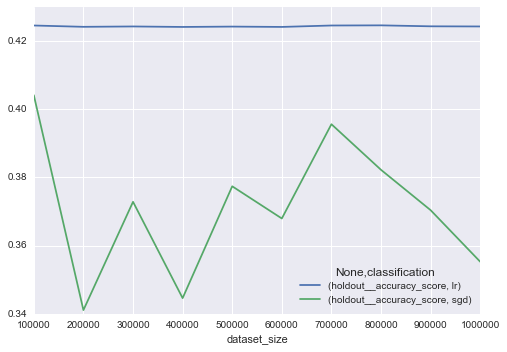

In [15]:
ax = df_holdout_accuracy.groupby(['classification', 'dataset_size']).mean().unstack('classification').plot()

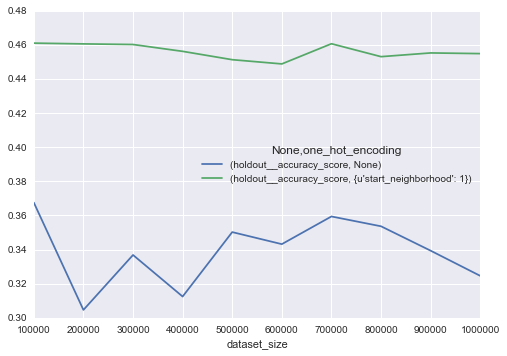

In [32]:
df_holdout_accuracy = df1[['dataset_size', 'one_hot_encoding', 'holdout__accuracy_score']]
ax = df_holdout_accuracy.groupby(['one_hot_encoding', 'dataset_size']).mean().unstack('one_hot_encoding').plot()

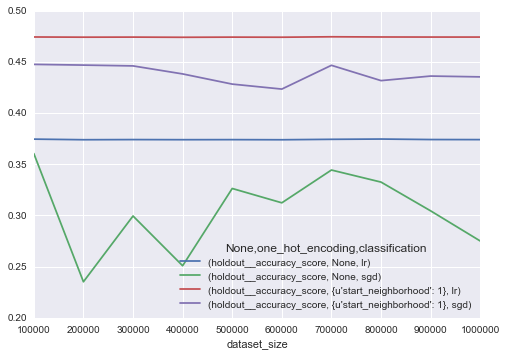

In [38]:
df_holdout_accuracy = df1[['dataset_size', 'classification','one_hot_encoding', 'holdout__accuracy_score']]
# ax = df_holdout_accuracy.groupby(['one_hot_encoding', 'dataset_size']).mean().unstack('one_hot_encoding').plot()
df_holdout_accuracy.groupby(['one_hot_encoding', 'classification','dataset_size']).groups
ax = df_holdout_accuracy.groupby(
    ['one_hot_encoding', 'classification', 'dataset_size']
).mean().unstack(['one_hot_encoding', 'classification']).plot()
